This study validates the accuracy of the JABIRU API in calculating energy differential intensity distributions of muons in the atmosphere. 

The datafile 'muons_circella.yaml' contains muon intensity data acquired using the CAPRICE particle detector during a balloon flight over Canada in 2001 [1]. 

The script calculates the same quantity using the JABIRU API and plots the two (See Figure 1).

[1] Circella, M. (2001). Primary cosmic ray and muon measurements with CAPRICE. Nuclear Physics B-Proceedings Supplements, 100(1-3), 127-129.

In [8]:
import codecs
import json
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import urllib.request
import yaml

<IPython.core.display.Javascript object>


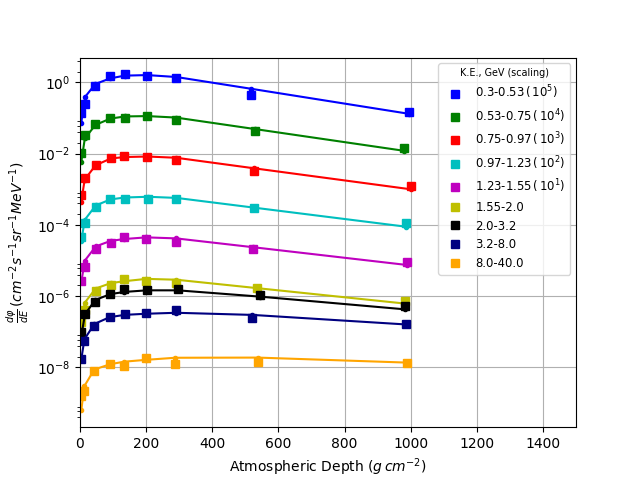

In [9]:
# initialise the figure
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k',  'navy', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'Atmospheric Depth $ (g \, cm^{-2})$')
ax.set_ylabel(r"$\frac{d \varphi}{d E} \, (cm^{-2} s^{-1} sr^{-1} MeV^{-1})$");

Figure 1: The differential intensity of vertical muons at atmospheric depths shown in the legend, as calculated by the Jabiru API (solid lines) and as measured by the CAPRICE apparatus (squares) [1]. Each curve is for the energy interval shown in the legend. Values are scaled by the factor given in parentheses in the legend for clarity.

In [10]:
# read the experimental data from file
with open('./muons_circella.yaml') as f : doc = yaml.load(f)
f.close()

In [11]:
#construct the base API URL to match experimental conditions
hostname = "https://api.amentum.space"
api_url = hostname + "/api/get_differential_intensity?"
api_url += "year=2001&"
api_url += "month=8&"
api_url += "day=9&"
api_url += "latitude=57&"
api_url += "longitude=-101&"
api_url += "particle=mu-&"
api_url += "angle=1.0&"

In [12]:
reader = codecs.getreader("utf-8")

In [13]:
# each plot/curve corresponds to a separate window of muon energies
for i, plot in enumerate(doc['particles'][0]['plots']):

    # set the color for this curve
    this_color = colors[i]

    # isolate and plot the experimental data for this curve
    depths = np.array(plot['data']).T[0]# g/cm2
    flux = np.array(plot['data']).T[1]# /m2/s/sr/GeV 

    lower_energy = plot['window'][0]# GeV
    upper_energy = plot['window'][1]

    #print('Energy window ', lower_energy, ' ', upper_energy)

    # create a label for the plot
    this_label = r"{0}-{1}".format(lower_energy, upper_energy)

    # each dataset is scaled by a factor for clarity in the plot 
    scaling = np.float(plot['scaling'])

    # calculate order of magnitude of the scaling factor, as an integer
    scaling_oom = np.int(np.log10(scaling))
    
    # add the scaling factor to the legend label for this plot
    if scaling_oom > 0 : this_label += r"$\, (\, 10^{})$".format(scaling_oom)

    # now add the plot to the graph
    ax.plot(depths  # g/cm2
        , flux*1e-4*1e-3  # /m2/s/sr/GeV --> /cm2/s/sr/MeV
        , linestyle = "None"
        , marker = "s"
        , label = this_label
        , color = this_color )
    
    # calculate intensities using the JABIRU API
    # the experimental data is effectively integrated over a range of energies, so
    # we need to do the same for the calculated data
    calc_flux_vs_depth = []
    
    # for each depth in the dataset
    for depth in depths:
        
        # complete the target URL according to atmospheric depth
        this_url = api_url + "atmospheric_depth=" + str(depth)
        
        # hit the Jabiru API and fetch the energy differential intensity distribution
        try:
            response = urllib.request.urlopen(this_url)
        except urllib.error.URLError as e: 
            ResponseData = e.reason
            print("ERROR: ", ResponseData)

        json_payload = json.load(reader(response))

        # isolate the kinetic energies and fluxes/intensities
        kes_api = json_payload["energies"]["data"] # MeV
        flux_api = json_payload["intensities"]["data"] # /cm2/s/sr/MeV
        
        # find the index of the lower and upper energy limit for this window in the calcuated spectrum
        # ensure the interpolation range is beyond the upper and lower window limits
        li = np.searchsorted(kes_api, lower_energy*1000.0)-1
        ui = np.searchsorted(kes_api, upper_energy*1000.0)+1
        
        # create 100 linearly spaced kinetic energies in the range of this energy window
        # ensure energies have units of MeV
        kes_lower_edges = np.linspace(np.float(lower_energy)*1000, np.float(upper_energy)*1000, 100)
        e_bin_width = kes_lower_edges[1] - kes_lower_edges[0]
        # calculate energies in the middle of each bin
        energy_mids = kes_lower_edges + e_bin_width/2.0
        # drop the last entry as it will fall outside the energy window range
        energy_mids = energy_mids[:-1] 
        
        # interpolate the flux at the middle of the energy bins 
        f = interpolate.interp1d(kes_api[li:ui], flux_api[li:ui])
        flux_mids = f(energy_mids)
                
        # integrate between the window limits
        integral_flux = np.trapz(flux_mids, x=energy_mids) # /cm2/s/sr  
        
        # experimental data is normalised to energy bin width 
        integral_flux /= ((upper_energy - lower_energy)*1000.0)
                        
        # append to the list 
        calc_flux_vs_depth.append(integral_flux)
    
    # convert to numpy array
    calc_flux_vs_depth = np.array(calc_flux_vs_depth)

    # 
    ax.plot(depths # MeV
        , calc_flux_vs_depth*scaling  # /cm2/s/sr/MeV
        , linestyle = "-"
        , marker = "."
        , color = colors[i])
    

In [14]:
ax.semilogy()
ax.grid()
ax.set_xlim(xmin = 0, xmax = 1500)
legend = ax.legend(title="K.E., GeV (scaling)",
    loc="upper right",
    fontsize = 'small',
    numpoints = 1)
plt.setp(legend.get_title(),fontsize='x-small')
plt.savefig("muons_circella.png")